In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [2]:

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X_train = model.encode(train_df["query"].tolist(), convert_to_tensor=True)
X_val = model.encode(val_df["query"].tolist(), convert_to_tensor=True)
X_test = model.encode(test_df["query"].tolist(), convert_to_tensor=True)

X_train = X_train.unsqueeze(1)
X_val   = X_val.unsqueeze(1)
X_test  = X_test.unsqueeze(1)

y_train = torch.tensor(train_df["carb"].values, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(val_df["carb"].values, dtype=torch.float32).unsqueeze(1)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

X_train.shape

torch.Size([8000, 1, 384])

In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=384, hidden_size=128, num_layers=3, dropout=0.4, bidirectional=False):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0, 
            bidirectional=bidirectional, 
            nonlinearity='relu'
            )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])    


Epoch 1, Train MSE: 1671.5258, RMSE: 40.88 grams
Validation MSE: 1183.6333, RMSE: 34.40 grams
Epoch 2, Train MSE: 1364.9837, RMSE: 36.95 grams
Validation MSE: 1100.7119, RMSE: 33.18 grams
Epoch 3, Train MSE: 1220.4369, RMSE: 34.93 grams
Validation MSE: 1050.2871, RMSE: 32.41 grams
Epoch 4, Train MSE: 1092.2760, RMSE: 33.05 grams
Validation MSE: 978.6607, RMSE: 31.28 grams
Epoch 5, Train MSE: 1008.2351, RMSE: 31.75 grams
Validation MSE: 934.8814, RMSE: 30.58 grams
Epoch 6, Train MSE: 872.6855, RMSE: 29.54 grams
Validation MSE: 1114.9529, RMSE: 33.39 grams
Epoch 7, Train MSE: 818.0411, RMSE: 28.60 grams
Validation MSE: 869.0173, RMSE: 29.48 grams
Epoch 8, Train MSE: 693.9744, RMSE: 26.34 grams
Validation MSE: 939.8011, RMSE: 30.66 grams
Epoch 9, Train MSE: 710.9888, RMSE: 26.66 grams
Validation MSE: 804.2958, RMSE: 28.36 grams
Epoch 10, Train MSE: 613.5635, RMSE: 24.77 grams
Validation MSE: 797.6250, RMSE: 28.24 grams
Epoch 11, Train MSE: 588.2569, RMSE: 24.25 grams
Validation MSE: 767.9

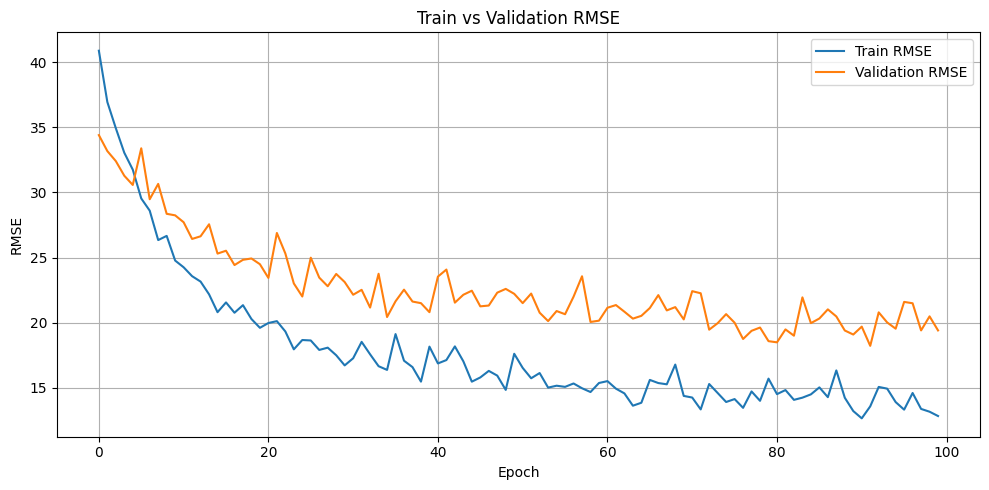

In [10]:

model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

epochs = 100

train_rmse_history = []
val_rmse_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    rmse = avg_loss ** 0.5
    print(f"Epoch {epoch+1}, Train MSE: {avg_loss:.4f}, RMSE: {rmse:.2f} grams")
    train_rmse_history.append(rmse)

    model.eval()
    total_val_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
    
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            total_val_loss += loss.item()
    
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())
    
    avg_val_loss = total_val_loss / len(val_loader)
    rmse = avg_val_loss ** 0.5
    val_rmse_history.append(rmse)
    print(f"Validation MSE: {avg_val_loss:.4f}, RMSE: {rmse:.2f} grams")

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rmse_RNN.png")  # or plt.show() to display in notebook
    

In [11]:
import seaborn as sns

class SentenceEmbeddingInterpreter:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        x.requires_grad = True
        self.input_tensor = x
        output = self.model(x)
        return output

    def zero_grad(self):
        self.model.zero_grad()
        if self.input_tensor.grad is not None:
            self.input_tensor.grad.zero_()

    def get_token_importance(self):
        grads = self.input_tensor.grad.detach().cpu().squeeze()      # [384]
        inputs = self.input_tensor.detach().cpu().squeeze()          # [384]
        importance = (grads * inputs).tolist()                       # Element-wise grad × input
        return importance

def visualize_sentence_embedding_importance(tokens, importances, filename=None):

    min_len = min(len(tokens), len(importances))
    tokens = tokens[:min_len]
    importances = importances[:min_len]

    fig, ax = plt.subplots(figsize=(15, 2.5))
    sns.heatmap([importances], annot=[tokens], cmap="Reds", fmt="", cbar=True, ax=ax)
    ax.set_title("Token Importance")
    plt.tight_layout()

    if filename:
        plt.savefig(filename)

    plt.show()  # ✅ This will display it in the notebook
    plt.close()

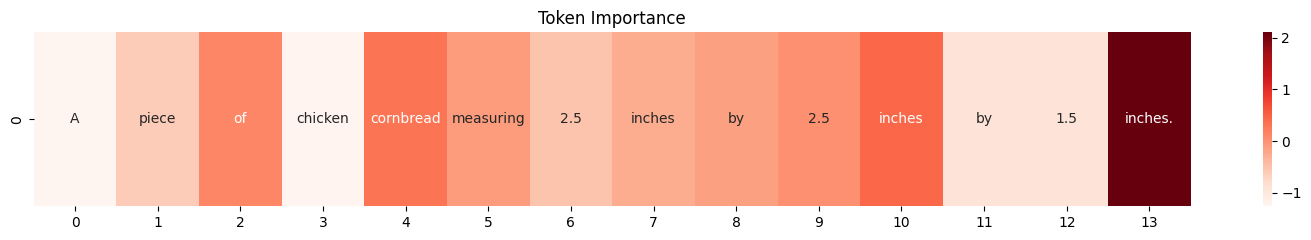

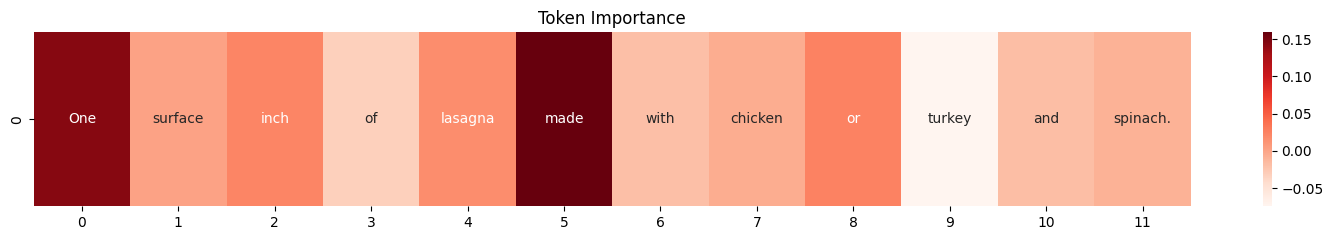

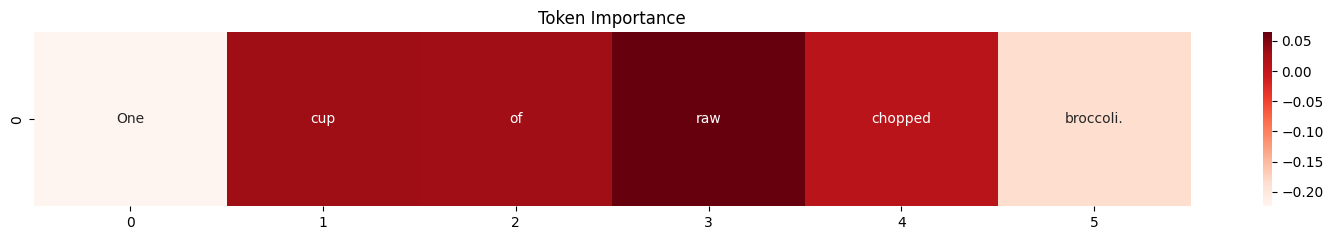

In [20]:
import random
for i in range (0,3):

    x = random.randint(0,99)
    sentence = test_df["query"].iloc[x]
    tokens = sentence.split()  # adjust if using tokenizer instead
    
    sample_x = X_val[i].unsqueeze(0).requires_grad_().to(torch.device("cpu"))
    
    interpreter = SentenceEmbeddingInterpreter(model)
    output = interpreter.forward(sample_x)
    interpreter.zero_grad()
    output.backward()
    
    importances = interpreter.get_token_importance()
    visualize_sentence_embedding_importance(tokens, importances)
